# MXNet + Transfer Learning
With TransferLearning Applied

[https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images](https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images)


In [2]:
# 1) download dataset
# 2) load into memory/convert to Torch dataset
# 3) choose transfer model -> resnet18 (44mb)
# 4) freeze original layers
# 5) add custom layers
# 6) train new layers added

In [1]:
!dir venv

zsh:1: command not found: dir


In [2]:
import torch
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

import pickle
from tqdm import tqdm
import os

In [3]:
class_names = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe',
'Lactarius', 'Russula', 'Suillus']

In [6]:
# lets investigate whats inside: в датасете не все mushrooms

! dir data\lab07\mushrooms

 ’®¬ ў гбва®©бвўҐ C Ё¬ҐҐв ¬ҐвЄг Windows
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : B052-935E

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ C:\pythonProject4\data\lab07\mushrooms

16.12.2023  14:45    <DIR>          .
16.12.2023  14:45    <DIR>          ..
16.12.2023  14:46    <DIR>          Agaricus
16.12.2023  14:46    <DIR>          Amanita
16.12.2023  14:45    <DIR>          Boletus
16.12.2023  14:45    <DIR>          Cortinarius
16.12.2023  14:45    <DIR>          Entoloma
16.12.2023  14:45    <DIR>          Hygrocybe
16.12.2023  14:45    <DIR>          Lactarius
16.12.2023  14:45    <DIR>          Russula
16.12.2023  14:45    <DIR>          Suillus
               0 д ©«®ў              0 Ў ©в
              11 Ї Ї®Є  45я717я770я240 Ў ©в бў®Ў®¤­®


In [7]:
import os
import shutil

def split_train_test(source_dir='./data/lab07/mushrooms', train_dir='./data/lab07-mushrooms-dataset/train', test_dir='./data/lab07-mushrooms-dataset/test'):
    for root, dirs, files in os.walk(source_dir):
        count = 0
        print(len(files))
        l = int(len(files)*0.2)
        for name in files:
            current_filepath = os.path.join(root, name)
            dataset_dir = train_dir if (l < count) else test_dir
            new_filepath = current_filepath.replace(source_dir, dataset_dir)
            try:
                os.makedirs(os.path.dirname(new_filepath))
            except FileExistsError:
                pass
            shutil.move(current_filepath, new_filepath)
            count += 1
    #shutil.rmtree(source_dir)




In [8]:
#split_train_test()

0
353
719
215
168
73
64
313
230
63


In [9]:
import torchvision
from torchvision.transforms import v2

TRAIN_FOLDER = './data/lab07-mushrooms-dataset/train/'
TEST_FOLDER = './data/lab07-mushrooms-dataset/test/'

# see https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html for details
transforms = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = torchvision.datasets.ImageFolder(root = TRAIN_FOLDER, transform = transforms)
test_dataset = torchvision.datasets.ImageFolder(root = TEST_FOLDER, transform = transforms)

C:\c python coding\venv\Scripts\pythonProject4\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [10]:
print(len(train_dataset), len(test_dataset))

1754 444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0
Label description: Agaricus
<built-in method size of Tensor object at 0x000001D98453B710>


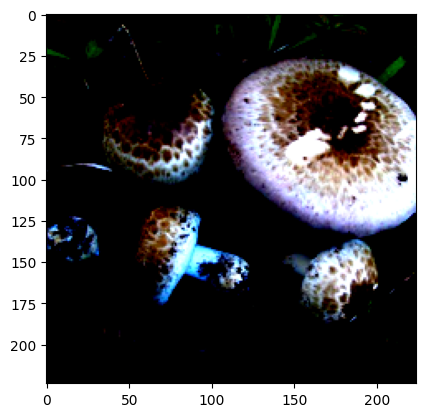

In [11]:
# show sample image, jusst to be sure, the dataset is working...

sample_idx = 32
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(np.array(data.permute(1, 2, 0)), cmap='gray')
print("Label: {}".format(label))
print("Label description: {}".format(train_dataset.classes[label]))
print(data.size)

In [50]:
print(np.array(data))

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [12]:
# setting device on GPU if available, else CPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [13]:
import torchvision.models as models

resnet18 = models.resnet18(weights='IMAGENET1K_V1')


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Владимир/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:13<00:00, 3.37MB/s]


In [14]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# test model as is
image, label = test_dataset[56]
label = test_dataset.classes[label]

predicted_label = resnet18(image[None, :])
print(get_imagenet_label(predicted_label))

NameError: name 'get_imagenet_label' is not defined

In [16]:
predicted_label

tensor([[-0.5768, -0.4680, -0.6670, -1.5566, -0.6667, -0.1592, -0.4957,  0.5156,
          0.3778, -0.6423, -1.1001, -0.8939, -0.4137, -1.0739, -1.2163, -0.6841,
         -0.9517, -0.4922, -0.6980, -0.7272, -1.6966, -0.8983, -1.5254,  0.1518,
         -1.0496, -1.1605, -0.7279, -1.1944, -0.9667, -0.3373, -0.7796, -0.7411,
         -0.4484, -0.5413, -0.4369, -0.5023,  0.6149, -0.6780, -0.3465,  0.1119,
         -0.5984, -0.8186, -1.0227, -0.2712, -0.5865, -0.4224, -0.6868, -0.4346,
         -1.1764, -0.9936, -0.4714,  0.4289, -0.2675, -0.6195,  0.0256, -1.0744,
         -0.3523, -1.4097, -0.3800, -0.4068,  0.8666,  0.2933, -0.0416,  0.1896,
         -0.6974, -0.1350, -0.1512, -0.2401, -0.7122, -1.0193, -1.4731,  0.0725,
         -1.3898, -0.2835, -1.1358, -1.4196,  0.0234, -0.4727,  0.1553,  0.2164,
         -0.9442, -1.7652, -0.1168, -0.7639, -0.5172, -0.2040,  0.0678,  0.2685,
         -0.0157, -0.8145, -1.2251, -1.1937, -1.9392, -0.4483,  0.0193, -2.2243,
         -0.5750, -0.5111, -

In [17]:
def get_imagenet_label(prediction_idx):

    with open("./data/lab07-mushrooms-dataset/imagenet1000_clsidx_to_labels.txt") as f:
        idx2label = eval(f.read())

    return idx2label[prediction_idx]


In [18]:
def show(image):
    plt.figure()
    plt.imshow(np.array(image.permute(1, 2, 0)))
    plt.show()

In [19]:
def predict_imagenet (model, image, k):
    prediction = model(image[None, :])
    
    top = torch.topk(prediction, k=k)
    print(top)

    for index, probability in zip(top.indices[0], top.values[0]):
        label = get_imagenet_label(index.item())
        print("{}: {:.2f}".format(label, probability.item()))

def predict (model, image, classes, k):
    prediction = model(image[None, :])
    
    top = torch.topk(prediction, k=k)
    print(top)

    for index, probability in zip(top.indices[0], top.values[0]):
        label = classes[index.item()]
        print("{}: {:.2f}".format(label, probability.item()))


In [20]:
image, _ = test_dataset[0]

predict_imagenet(resnet18, image, 3)
show(image)

torch.return_types.topk(
values=tensor([[2.6097, 2.1975, 2.1259]], grad_fn=<TopkBackward0>),
indices=tensor([[463, 731, 600]]))


FileNotFoundError: [Errno 2] No such file or directory: './data/lab07-mushrooms-dataset/imagenet1000_clsidx_to_labels.txt'

In [21]:
for param in resnet18.parameters():
    param.requires_grad = False

In [23]:
# Parameters of newly constructed modules have requires_grad=True by default
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 9)

resnet18 = resnet18.to(device)

# print new model
print(resnet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
import torchvision.models as models

OUT_FEATURES = 9

def build_model():
    #model = models.resnet18(weights='IMAGENET1K_V1')
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    for param in model.parameters():
        param.requires_grad = False
        
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    # Parameters of newly constructed modules have requires_grad=True by default
    #num_features = model.fc.in_features
    model.fc = nn.Linear(model.fc.in_features, OUT_FEATURES)
        
        #nn.Sequential(
        #nn.Linear(num_features, OUT_FEATURES)
        #nn.Linear(num_features, 1024),
        #nn.ReLU(),
        #nn.Linear(1024, 512),
        #nn.ReLU(),
        #nn.Linear(512, 64),
        #nn.ReLU(),
        #nn.Linear(64, OUT_FEATURES)
    #))
    
    model.fc.apply(init_weights)
    
    return model


In [25]:
print(build_model())

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Владимир/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:23<00:00, 4.45MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [30]:
# prepare training
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.005

resnet_transfer = build_model()
resnet_transfer = resnet_transfer.to(device)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

hist = train(resnet_transfer, train_dataloader, device, EPOCHS, LR)

Epoch: 0, Batch:  2, Loss: 6.67, Acc: 0.03:   1%|▎                                                           | 3/550 [00:23<1:12:39,  7.97s/it]


OSError: image file is truncated (92 bytes not processed)

In [28]:
print_history(hist, 'resnet18_transfer')

NameError: name 'hist' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.return_types.topk(
values=tensor([[1.2228, 1.0642, 0.2157]], grad_fn=<TopkBackward0>),
indices=tensor([[6, 7, 2]]))
Lactarius: 1.22
Russula: 1.06
Boletus: 0.22


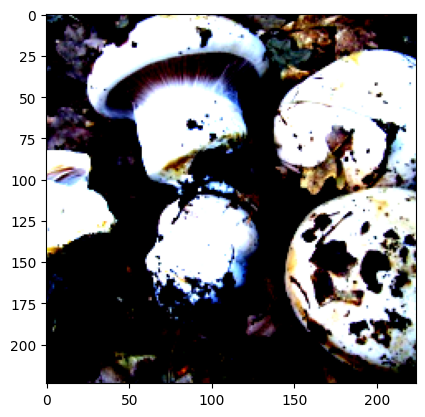

True label:  Cortinarius


In [30]:
image, label = test_dataset[654]

predict(resnet_transfer, image, test_dataset.classes, 3)
show(image)
print('True label: ', test_dataset.classes[label])